# Kenn Experiments - Plots and Statistics
Run this notebook only after all the tests have been run. 

In [1]:
from model import *
from pre_elab import *
from evaluation_functions import *
import settings as s
import pickle

# Inductive Learning 

In [2]:
with open('results/e2e/results_inductive_500','rb') as input:
    history_inductive = pickle.load(input)

== 10% ==
Mean Test Accuracy:	NN = 0.543966; KENN = 0.591556
Test Accuracy std:	NN = 0.060093; KENN = 0.055222
			Deltas Mean = 0.047591
			Deltas Std = 0.080025
			right tailed p-value: 3.217535677766969e-36

== 25% ==
Mean Test Accuracy:	NN = 0.629543; KENN = 0.670805
Test Accuracy std:	NN = 0.019920; KENN = 0.015488
			Deltas Mean = 0.041262
			Deltas Std = 0.022021
			right tailed p-value: 6.596625677718746e-183

== 50% ==
Mean Test Accuracy:	NN = 0.679635; KENN = 0.714310
Test Accuracy std:	NN = 0.019224; KENN = 0.013485
			Deltas Mean = 0.034675
			Deltas Std = 0.022007
			right tailed p-value: 4.7148054539048204e-157

== 75% ==
Mean Test Accuracy:	NN = 0.733157; KENN = 0.753947
Test Accuracy std:	NN = 0.024646; KENN = 0.017082
			Deltas Mean = 0.020790
			Deltas Std = 0.026766
			right tailed p-value: 2.2575118975119134e-48

== 90% ==
Mean Test Accuracy:	NN = 0.758828; KENN = 0.768489
Test Accuracy std:	NN = 0.027678; KENN = 0.024150
			Deltas Mean = 0.009662
			Deltas Std = 0.0

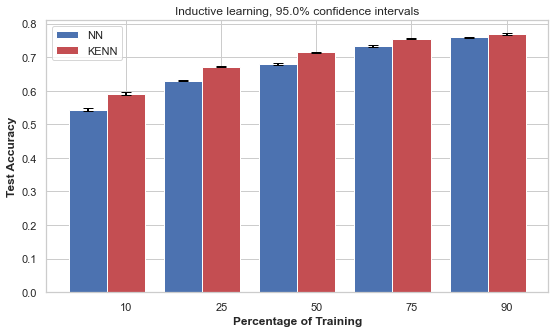

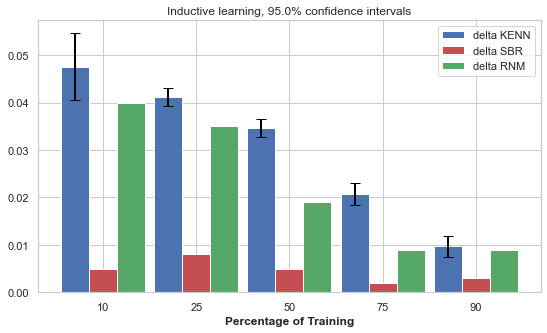

In [3]:
conf= 0.95

print_and_plot_results(
    history_inductive, 
    plot_title="Inductive learning, {}% confidence intervals".format(conf*100),
    other_deltas='i',
    confidence_level=conf)

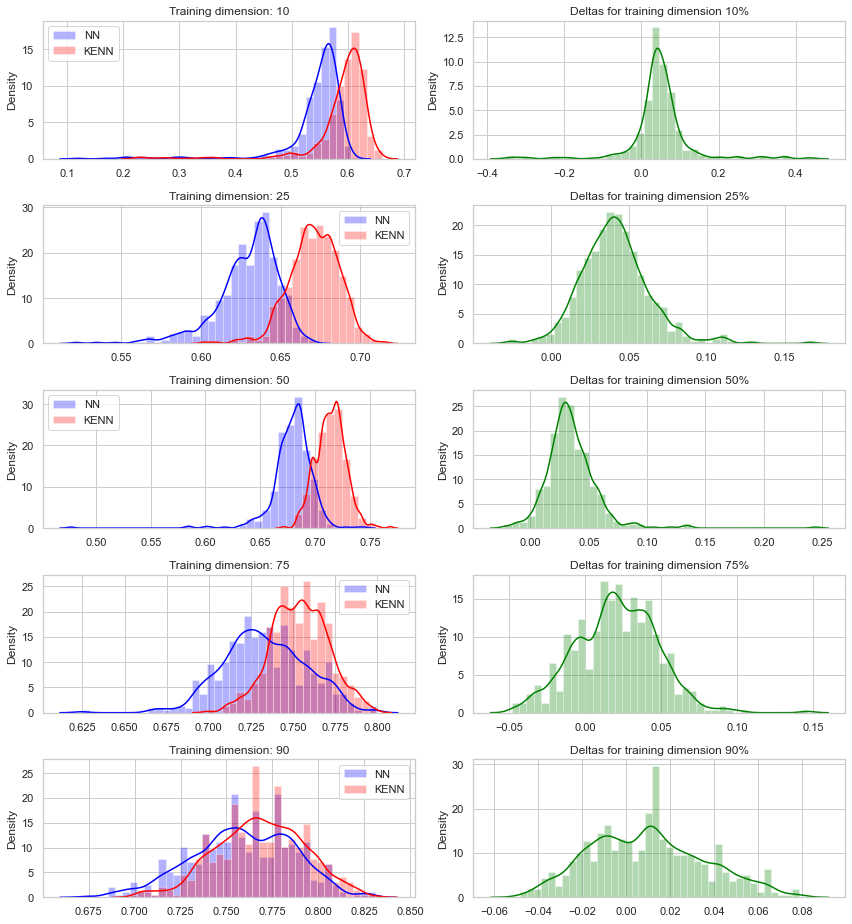

In [4]:
plot_histograms(history_inductive, 'history_inductive', bw=0.6, bins=40)

# Transductive Learning

In [5]:
with open('results/e2e/results_transductive_500','rb') as input:
    history_transductive = pickle.load(input)

== 10% ==
Mean Test Accuracy:	NN = 0.543971; KENN = 0.651944
Test Accuracy std:	NN = 0.060092; KENN = 0.015203
			Deltas Mean = 0.107972
			Deltas Std = 0.059021
			right tailed p-value: 5.585540523199004e-162

== 25% ==
Mean Test Accuracy:	NN = 0.629535; KENN = 0.702190
Test Accuracy std:	NN = 0.019921; KENN = 0.012466
			Deltas Mean = 0.072655
			Deltas Std = 0.022009
			right tailed p-value: 0.0

== 50% ==
Mean Test Accuracy:	NN = 0.679662; KENN = 0.744209
Test Accuracy std:	NN = 0.019238; KENN = 0.013879
			Deltas Mean = 0.064547
			Deltas Std = 0.022497
			right tailed p-value: 1.6e-322

== 75% ==
Mean Test Accuracy:	NN = 0.733157; KENN = 0.788355
Test Accuracy std:	NN = 0.024646; KENN = 0.017632
			Deltas Mean = 0.055198
			Deltas Std = 0.026672
			right tailed p-value: 8.523217587587243e-207

== 90% ==
Mean Test Accuracy:	NN = 0.758828; KENN = 0.808103
Test Accuracy std:	NN = 0.027678; KENN = 0.022381
			Deltas Mean = 0.049275
			Deltas Std = 0.026307
			right tailed p-value: 2.

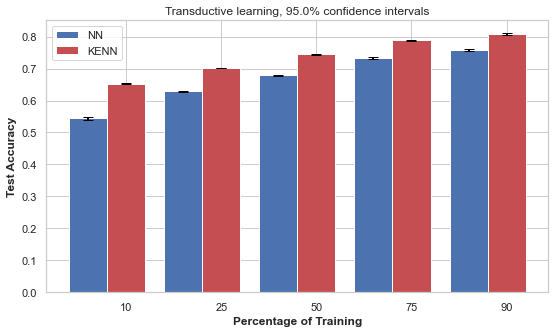

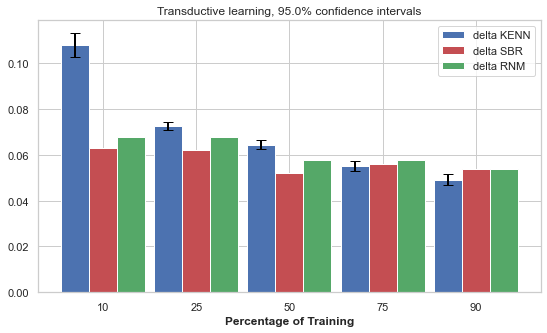

In [6]:
conf= 0.95

print_and_plot_results(
    history_transductive, 
    plot_title="Transductive learning, {}% confidence intervals".format(conf*100),
    other_deltas='t',
    confidence_level=conf)

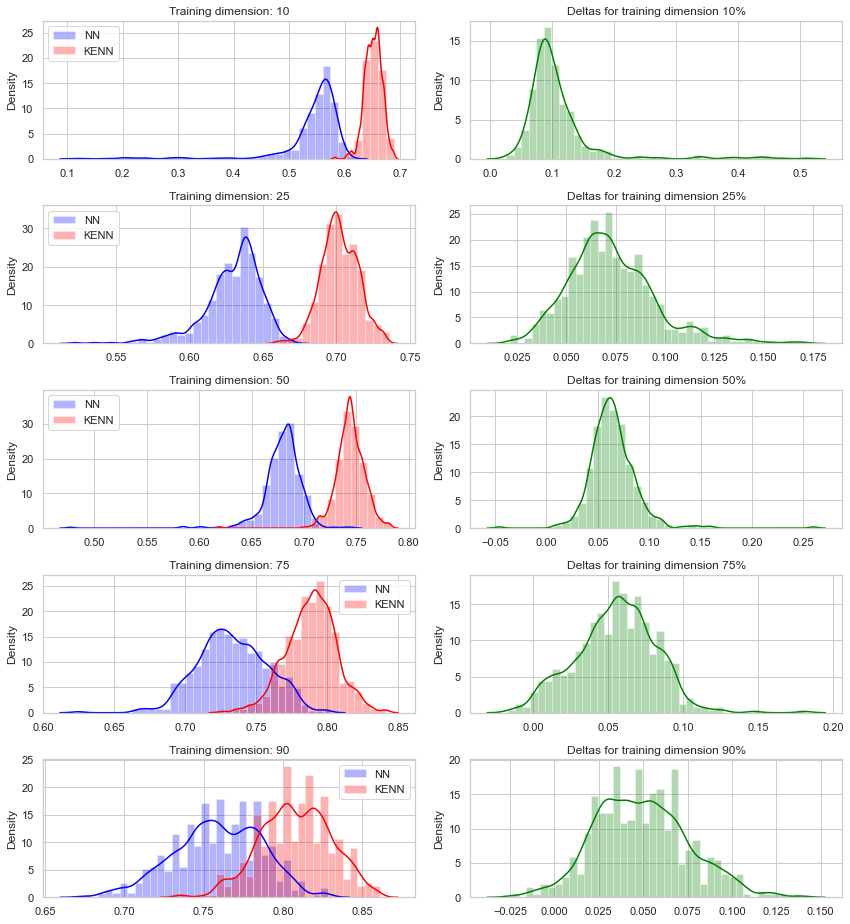

In [7]:
plot_histograms(history_transductive, 'history_transductive', bw=0.6, bins=40)